In [12]:
%load_ext autoreload
%autoreload 2

# 3rd party imports
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
np.set_printoptions(linewidth=1000)

from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint


# Local imports
import modules.laplacian as laplacian
import modules.jacobian as jacobian
import modules.correspondences as correspondences

import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Iterative SLSQP

In [13]:
# define helper functions

def idx_adjacency(shape):
    idx_adj = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                adjacent_indices = laplacian.get_adjacent_indices(z, y, x, shape)
                idx_adj[l_idx] = adjacent_indices
    return idx_adj

# Define the objective function
def objective(phi, A_, b_):
    return np.linalg.norm(A_ @ phi - b_)**2

# Define the objective function
def objective2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init) + np.linalg.norm(A_ @ phi - b_)

def objective3(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init)

def objectiveManh2(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1) + np.linalg.norm(A_ @ phi - b_)

def objectiveManh(phi, phi_init, A_, b_):
    return np.linalg.norm(phi - phi_init, ord=1)


def nearest_center(shape, n):
    near_cent = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                l_idx = laplacian.get_laplacian_index(z, y, x, shape)
                z_cent = z
                y_cent = y
                x_cent = x
                if (x-n < 0):
                    x_cent = n
                elif (shape[2]-x < n+1):
                    x_cent = shape[2]-n-1

                if (y-n < 0):
                    y_cent = n
                elif (shape[1]-y < n):
                    y_cent = shape[1]-n-1
                center_indices = [z, y_cent, x_cent]
                near_cent[l_idx] = center_indices
                # print("Nearest center values for index ", l_idx, center_indices)
    return near_cent

def original_coordinates(shape):
    ori_coord = {}
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                ori_coord[z * shape[1] * shape[2] + y * shape[2] + x] = (z,y,x)
    return ori_coord


def get_phi_sub_flat(phi, cz, cy, cx, shape, d):
    phix = phi[1, cy-d:cy+d+1, cx-d:cx+d+1]
    phiy = phi[0, cy-d:cy+d+1, cx-d:cx+d+1]
    return np.concatenate([phix.flatten(), phiy.flatten()])


In [14]:
# jacobian functions

def jacobian_det2D(phi_xy):
    deformation = np.zeros((3,1, *phi_xy.shape[-2:])    )
    deformation[2] = phi_xy[1]
    deformation[1] = phi_xy[0]
    return jacobian.sitk_jacobian_determinant(deformation)

def jdet_constraint2(phi_sub, phi, idx_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, ori_shape, epsilon=1e-6):
    start = time.time()
    dist = submatrix_size//2
    pixels = submatrix_size*submatrix_size
    phi[1, cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[:pixels].reshape((submatrix_size, submatrix_size))
    phi[0, cy-dist:cy+dist+1, cx-dist:cx+dist+1] = phi_sub[pixels:].reshape((submatrix_size, submatrix_size))

    phi = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    z,y,x = sub_ori_coord[idx_sub]
    z = z
    y = y+cy-dist
    x = x+cx-dist 

    idx = laplacian.get_laplacian_index(z,y,x, ori_shape)


    left_idx, right_idx, up_idx, down_idx = idx_adj[idx]
    
    if left_idx is None:  # Left edge
        dxx = (phi[right_idx] - phi[idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[idx + y_offset]) / 2
    elif right_idx is None:  # Right edge
        dxx = (phi[idx] - phi[left_idx]) / 2
        dyx = (phi[idx + y_offset] - phi[left_idx + y_offset]) / 2
    else: 
        dxx = (phi[right_idx] - phi[left_idx]) / 2
        dyx = (phi[right_idx + y_offset] - phi[left_idx + y_offset]) / 2
    
    if up_idx is None:  # Top edge
        dyy = (phi[down_idx + y_offset] - phi[idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[idx]) / 2
    elif down_idx is None:  # Bottom edge
        dyy = (phi[idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[idx] - phi[up_idx]) / 2
    else:
        dyy = (phi[down_idx + y_offset] - phi[up_idx + y_offset]) / 2
        dxy = (phi[down_idx] - phi[up_idx]) / 2
    
    end = time.time()
    # print(f'Jdet computed in {end-start}s')
    # print(f'jdet2 for {z,y,x} - {dxx, dyy, dxy, dyx}')
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

def jdet_constraint3(phi, cx, cy, cz, submatrix_size, ori_shape, epsilon=1e-6):
    constraints = []
    dist = submatrix_size//2
    for zi in range(1):
        for yi in range(cy-dist, cy+dist+1):
            for xi in range(cx-dist, cx+dist+1):
                constraints += [{'type': 'ineq', 'fun': lambda phi1: compute_jdet_for_pixel(phi1, phi, dist, zi, yi, xi, cz, cy, cx, submatrix_size, ori_shape, epsilon)}]

    return constraints


def compute_jdet_for_pixel(phi1, phi, dist, zi, yi, xi, cz, cy, cx, submatrix_size, ori_shape, epsilon=1e-6):
    # see if there is a way out of reshaping the submatrix too
    
    start = time.time()
    pixels = submatrix_size*submatrix_size
    phi_sub = np.zeros((2, submatrix_size, submatrix_size))
    phi_sub[1] = phi1[:pixels].reshape((submatrix_size, submatrix_size))
    phi_sub[0] = phi1[pixels:].reshape((submatrix_size, submatrix_size))
    
    left = xi-1
    right = xi+1
    top = yi-1
    bottom = yi+1
    
    xi_sub = xi-cx+dist
    left_sub = left-cx+dist
    right_sub = right-cx+dist

    yi_sub = yi-cy+dist
    top_sub = top-cy+dist
    bottom_sub = bottom-cy+dist

    # print(f'boundaries: {cx-dist, left, right, cx+dist, ori_shape[-1], cy-dist, top, bottom, cy+dist, ori_shape[-2]}')
    if left < cx-dist: # left edge of sub
        if left < 0: # leftmost edge
            dxx = (phi_sub[1, yi_sub, right_sub] - phi_sub[1, yi_sub, xi_sub]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi_sub[0, yi_sub, xi_sub]) / 2
        else:
            dxx = (phi_sub[1, yi_sub, right_sub] - phi[1, yi, left]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi[0, yi, left]) / 2
    else:
        if right > cx+dist: # right edge of sub
            if right > ori_shape[-1]-1: # rightmost edge
                dxx = (phi_sub[1, yi_sub, xi_sub] - phi_sub[1, yi_sub, left_sub]) / 2
                dyx = (phi_sub[0, yi_sub, xi_sub] - phi_sub[0, yi_sub, left_sub]) / 2
            else:
                # print(f'{yi, right, left_sub}')
                dxx = (phi[1, yi, right] - phi_sub[1, yi_sub, left_sub]) / 2
                dyx = (phi[0, yi, right] - phi_sub[0, yi_sub, left_sub]) / 2
        else: # inside the submatrix
            dxx = (phi_sub[1, yi_sub, right_sub] - phi_sub[1, yi_sub, left_sub]) / 2
            dyx = (phi_sub[0, yi_sub, right_sub] - phi_sub[0, yi_sub, left_sub]) / 2

    if top < cy-dist: # top edge of sub
        if top < 0: # topmost edge
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi_sub[1, yi_sub, xi_sub]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi_sub[0, yi_sub, xi_sub]) / 2
        else:
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi[1, top, xi]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi[0, top, xi]) / 2
    else:
        if bottom > cy+dist: # bottom edge of sub
            if bottom > ori_shape[-2]-1: # bottom most edge
                dxy = (phi_sub[1, yi_sub, xi_sub] - phi_sub[1, top_sub, xi_sub]) / 2
                dyy = (phi_sub[0, yi_sub, xi_sub] - phi_sub[0, top_sub, xi_sub]) / 2
            else:
                dxy = (phi[1, bottom, xi] - phi_sub[1, top_sub, xi_sub]) / 2
                dyy = (phi[0, bottom, xi] - phi_sub[0, top_sub, xi_sub]) / 2
        else: # inside the submatrix
            dxy = (phi_sub[1, bottom_sub, xi_sub] - phi_sub[1, top_sub, xi_sub]) / 2
            dyy = (phi_sub[0, bottom_sub, xi_sub] - phi_sub[0, top_sub, xi_sub]) / 2
    end = time.time()

    # print(f'Jdet3 computed in {end-start}s')
    # print(f'jdet3 for {zi, yi_sub, xi_sub} - - {dxx, dyy, dxy, dyx}')
    return ((dxx + 1) * (dyy + 1)) - (dxy * dyx) - epsilon

                

In [15]:
def jacobian_constraint(phi_xy, submatrix_size):
    deformation = np.zeros((3,1, submatrix_size, submatrix_size))
    pixels = submatrix_size*submatrix_size
    deformation[2] = phi_xy[:pixels].reshape((submatrix_size, submatrix_size))
    deformation[1] = phi_xy[pixels:].reshape((submatrix_size, submatrix_size))
    return jacobian.sitk_jacobian_determinant(deformation).flatten()

In [16]:
def iterative_with_jacobians(deformation_i, methodName='SLSQP'):
    '''perform SLSQP on submatrices iteratively'''
    slice_shape = (1, *deformation_i.shape[-2:])

    # this phi will be updated iteratively
    phi = np.zeros((2, *deformation_i.shape[-2:]))
    phi[1] = deformation_i[-1]
    phi[0] = deformation_i[-2]
    print(f'deformation_i shape: {deformation_i.shape}, phi_init shape: {phi.shape}')
    phi_init = phi.copy()

    # set threshold for Jacobian and store results
    threshold = 0.0
    jacobians = []
    indi_times = []
    tot_start = time.time()

    # collect indices with -ve Jacobians into a list in a sorted fashion
    J_init = jacobian_det2D(phi)
    jacobians.append(J_init)
    J_init = J_init.flatten()
    neg_jacobian_indices = np.where(J_init <= threshold)[0]
    neg_jacobian_indices = neg_jacobian_indices[np.argsort(J_init[neg_jacobian_indices])].tolist()
    print(f'init: Negative Jacobians found at {neg_jacobian_indices}')

    # set values to use inside the while loop
    idx_adj = idx_adjacency(slice_shape)
    y_offset = len(J_init)//2
    # find the nearest center of a 5x5 matrix around each pixel
    submatrix_size = 5
    near_cent = nearest_center(slice_shape, submatrix_size//2)
    ori_coord = original_coordinates(slice_shape)


    sub_shape = (1,submatrix_size, submatrix_size)
    sub_ori_coord = original_coordinates(sub_shape)
    _, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3)))

    visited = {}
    max_visits = 3
    ind = 0

    
    # perform optimisation for each index with negative Jacobian
    while ind < len(neg_jacobian_indices) and ind < 50:
        neg_index  = neg_jacobian_indices[ind]
        ind += 1
        # if the negative values has already been fixed, skip it
        jdet_value = jacobian_det2D(phi).flatten()[neg_index]
        if (jdet_value > threshold):
            print(f'Iter {ind}: jacobian at index {neg_index} is +ve. skip.')
            continue

        # check number of visits to this index and increase submatrix size if necessary
        visits = visited.get(neg_index, 0) + 1
        visited[neg_index] = visits

        # increase submatrix size if not sufficient
        if (visits > max_visits and submatrix_size + 2 <= min(slice_shape[1:])):
            # increase subshape and everything that depends on it
            submatrix_size+=2
            max_visits += 1
            print(f'Submatrix size is {submatrix_size} from index {neg_index}')
            near_cent = nearest_center(slice_shape, submatrix_size//2)
            ori_coord = original_coordinates(slice_shape)
            sub_shape = (1,submatrix_size, submatrix_size)
            sub_ori_coord = original_coordinates(sub_shape)
            _, A_sub, b_sub = laplacian.compute3DLaplacianFromShape(sub_shape, np.empty((0,3)), np.empty((0,3)))
        
        z,y,x = ori_coord[neg_index]
        cz, cy, cx = near_cent[neg_index]

        print(f'Iter {ind}: Analysing index {neg_index}: Original coord: {x,y,z}, nearest: {cx, cy, cz}, jdet: {jdet_value}')

        # get constraints for optimisation
        # constraints = []
        # for i_sub in range(len(b_sub)//2):
        #     constraints += [{'type': 'ineq', 'fun': lambda phi1, i=i_sub: jdet_constraint2(phi1, phi.copy(), i, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, slice_shape, 0.05)}]
        
        # constraints = jdet_constraint3(phi, cx, cy, cz, submatrix_size, slice_shape, 0.05)

        op_start = time.time()

        phi_init_sub_flat = get_phi_sub_flat(phi_init, cz, cy, cx, slice_shape, submatrix_size//2)
        phi_sub_flat = get_phi_sub_flat(phi, cz, cy, cx, slice_shape, submatrix_size//2)

        # set Jacobian constraints - with boundaries
        nonlinear_constraints = NonlinearConstraint(lambda phi1: jacobian_constraint(phi1, submatrix_size), 0.05, np.inf)
        
        # Create equality constraints to fix edge values
        edge_mask = np.zeros((submatrix_size, submatrix_size), dtype=bool)
        edge_mask[[0, -1], :] = True
        edge_mask[:, [0, -1]] = True

        edge_indices = np.argwhere(edge_mask)
        fixed_indices = []
        y_offset_sub = submatrix_size*submatrix_size
        for y, x in edge_indices:
            idx = y*submatrix_size + x
            fixed_indices.extend([idx, idx + y_offset_sub])

        fixed_values = phi_sub_flat[fixed_indices]

        A_eq = np.zeros((len(fixed_indices), phi_sub_flat.size))
        for row, idx in enumerate(fixed_indices):
            A_eq[row, idx] = 1

        linear_constraint = LinearConstraint(A_eq, fixed_values, fixed_values)
        constraints=[nonlinear_constraints, linear_constraint]
        
        # in objective, should i use latest phi or the very initial phi_init to penalise?
        # it is running when initial pt is new phi AND objective uses new phi!
        result = minimize(lambda phi1: objectiveManh(phi1, phi_init_sub_flat, A_sub, b_sub), phi_sub_flat, constraints=constraints, options={'maxiter': 1000, 'disp': True}, method=methodName)
        
        op_end = time.time()

        print(f'Optimisation for index {neg_index} completed in {op_end-op_start}s')

        indi_times.append(op_end-op_start)
        
        if result.success:
            print(f'OP result error for index {neg_index}: {result.fun}')
        else:
            print("Optimisation failed: ", result.message)

        # substitute values from computed deformation into original phi
        # b_ was XYd, so phi_x is the first half
        phi_x_res = result.x[:len(result.x) // 2].reshape(sub_shape[-2:])
        phi_y_res = result.x[len(result.x) // 2:].reshape(sub_shape[-2:])

        center_distance = submatrix_size//2
        
        phi[1, cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_x_res
        phi[0, cy-center_distance:cy+center_distance+1, cx-center_distance:cx+center_distance+1] = phi_y_res
        
        # compute jacobian and add to list
        J = jacobian_det2D(phi)
        jacobians.append(J)

        # check for -ve jacobians in modified deformation
        J = J.flatten()
        neg_j_iter = np.where(J <= threshold)[0]
        neg_j_iter = neg_j_iter[np.argsort(J[neg_j_iter])]

        print(f'Iter {ind} end: {len(neg_j_iter)} -ve jacs now at {neg_j_iter} : SITK: {J[neg_j_iter]}')

        # add new negative jacobian indices to list
        for new_neg in neg_j_iter:
            if new_neg not in neg_jacobian_indices[ind:]:
                neg_jacobian_indices.append(new_neg)


    # compute errors
    phi_flat = np.concatenate([phi[1].flatten(), phi[0].flatten()])
    phi_init_flat = np.concatenate([phi_init[1].flatten(), phi_init[0].flatten()])

    _, A_, b_ = laplacian.compute3DLaplacianFromShape(slice_shape, np.empty((0,3)), np.empty((0,3)))
    init_error = objective2(phi_init_flat, phi_init_flat, A_, b_)
    fin_error = objective2(phi_flat, phi_init_flat, A_, b_)
    deviation = np.sqrt(np.sum((phi_flat - phi_init_flat)**2))

    tot_end = time.time()
    print(f'Total time taken for iterative SLSQP : {tot_end - tot_start} split as {indi_times}')
    print(f'Initial error: {init_error}, final error: {fin_error}, deviation: {deviation}')
    
    
    return phi, jacobians

In [17]:
# # Testing Jacobian computations
# msample = np.array([
#     [0, 2, 0],
#     [0, 3, 1],
#     [0, 10, 5],
#     [0, 13, 1],
#     [0, 2, 39],
#     [0, 3, 38],
#     [0, 10, 35],
#     [0, 13, 39],
# ])
# fsample = np.array([
#     [0, 2, 4],
#     [0, 3, 2],
#     [0, 10, 3],
#     [0, 11, 6],
#     [0, 2, 30],
#     [0, 3, 36],
#     [0, 10, 37],
#     [0, 11, 34]
# ])

# fixed_sample = np.zeros((1, 10, 10))

# deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
# phi = np.zeros((2, *deformation_i.shape[-2:]))
# phi[1] = deformation_i[-1]
# phi[0] = deformation_i[-2]
# phi2 = phi.copy()

# # get constraints for optimisation
# cz = 0
# cy = 5
# cx = 5
# slice_shape = fixed_sample.shape
# submatrix_size = 5
# y_offset = slice_shape[1]*slice_shape[2]

# idx_adj = idx_adjacency(slice_shape)
# phi1 = get_phi_sub(phi, cz, cy, cx, slice_shape, submatrix_size//2)

# sub_shape = (1,submatrix_size, submatrix_size)
# sub_ori_coord = original_coordinates(sub_shape)
# constraints = []

# start = time.time()
# for i_sub in range(25):
#     print(jdet_constraint2(phi1, phi, i_sub, cx, cy, cz, submatrix_size, idx_adj, y_offset, sub_ori_coord, slice_shape, 1e-6))
# start2 = time.time()

# print("==========================================")

# dist = submatrix_size//2
# for zi in range(1):
#     for yi in range(cy-dist, cy+dist+1):
#         for xi in range(cx-dist, cx+dist+1):
#             print(compute_jdet_for_pixel(phi1, phi2, dist, zi, yi, xi, cz, cy, cx, submatrix_size, slice_shape, 1e-6))

# end = time.time()
# print(f'Time taken: {start2-start}s and {end-start2}s')

## preprocessing and plotting methods

In [18]:
def plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10)):
    jacobian_initial = jacobian_det2D(deformation_i[1:])
    jacobian_final = jacobian_det2D(phi_corrected)

    # print("JACOBIAN SHAPES", jacobian_initial.shape, jacobian_final.shape)

    # Create DataFrame
    data = {
        ("x-def", "min"): [np.min(deformation_i[2,0]), np.min(phi_corrected[1])],
        ("x-def", "max"): [np.max(deformation_i[2,0]), np.max(phi_corrected[1])],
        ("y-def", "min"): [np.min(deformation_i[1,0]), np.min(phi_corrected[0])],
        ("y-def", "max"): [np.max(deformation_i[1,0]), np.max(phi_corrected[0])],
        ("jacobian", "min"): [np.min(jacobian_initial), np.min(jacobian_final)],
        ("jacobian", "max"): [np.max(jacobian_initial), np.max(jacobian_final)]
    }

    row_names = ["initial", "final"]
    df = pd.DataFrame(data, index=row_names)

    # Print table
    print(df)


    # plot initial vs final Jacobian
    norm = mcolors.TwoSlopeNorm(vmin=min(jacobian_initial.min(), jacobian_final.min(), -1), vcenter=0, vmax=max(jacobian_initial.max(), jacobian_final.max(), 1))


    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize)

    # jacobians are of shape (1,5,5). Use index [0] for 2D plots
    im0 = axs[0,0].imshow(jacobian_initial[0], cmap='seismic', norm=norm, interpolation='nearest')
    im1 = axs[0,1].imshow(jacobian_final[0], cmap='seismic', norm=norm, interpolation='nearest')

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0,0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation_i.shape[3]), range(deformation_i.shape[2]), indexing='xy')
    print(f'meshgrid shape for plot: {x.shape}')
    
    axs[0,0].set_title('Initial J det')
    axs[0,0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
    axs[0,0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
    axs[0,0].legend()

    axs[0,1].set_title('final J det')

    axs[1,0].set_title('Initial deformation')
    axs[1,0].quiver(x, y, -deformation_i[2,0], deformation_i[1,0])

    axs[1,1].set_title('final deformation')
    axs[1,1].quiver(x, y, -phi_corrected[1], phi_corrected[0])

    for i in range(2):
        axs[1,i].invert_yaxis()
    
    #fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.95, 0.5, 0.02, 0.4])
    fig.colorbar(im1, cax=cax)

In [19]:
def plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP'):
    # assume jacobians is a list of numpy arrays of shape (1, 5, 5)
    # assume msample and fsample are (N, 3) arrays

    num_jacobians = len(jacobians)
    ncols = min(2, num_jacobians)  # wrap at 2 columns
    nrows = (num_jacobians + ncols - 1) // ncols  # ceiling division

    # Compute color normalization
    all_vals = [j[0] for j in jacobians]  # extract 2D arrays from (1,5,5)
    vmin = min(j.min() for j in all_vals)
    vmax = max(j.max() for j in all_vals)
    norm = mcolors.TwoSlopeNorm(vmin=min(vmin, -1), vcenter=0, vmax=max(vmax, 1))

    # Create subplots
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))
    axs = axs.flatten()

    for i, jac in enumerate(jacobians):
        im = axs[i].imshow(jac[0], cmap='seismic', norm=norm, interpolation='nearest')
        num_negs = np.sum(jac <= 0)
        axs[i].set_title(f'Jacobian #{i}, {num_negs} -ves' if i > 0 else f'Initial J det: {num_negs} -ves')

        if i == 0:
            axs[i].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving', s=10)
            axs[i].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed', s=10)
            axs[i].legend()

    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.1, headwidth=3, headlength=5, width=1)
        )

    # Hide any extra axes
    for j in range(len(jacobians), len(axs)):
        axs[j].axis('off')

    # Add colorbar
    # cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    # fig.colorbar(im, cax=cax)
    fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

def run_lapl_and_correction(fixed_sample, msample, fsample, methodName='SLSQP'):
    '''plot each Jacobian matrix'''
    deformation_i, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)
    print(f'deformation shape: {deformation_i.shape}')
    phi_corrected, jacobians = iterative_with_jacobians(deformation_i, methodName)
    plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
    plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))

## Some more testcases

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [5, 46, 16, 33, 14, 15, 86, 85, 34, 56]
Iter 1: Analysing index 5: Original coord: (5, 0, 0), nearest: (5, 2, 0), jdet: -1.8710779020733441
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.742003383918934
            Iterations: 56
            Function evaluations: 2952
            Gradient evaluations: 56
Optimisation for index 5 completed in 1.8152899742126465s
OP result error for index 5: 13.742003383918934
Iter 1 end: 6 -ve jacs now at [16 33 14 15 34 56] : SITK: [-1.07010932 -0.73103384 -0.49995084 -0.48991491 -0.04804801 -0.04657853]
Iter 2: jacobian at index 46 is +ve. skip.
Iter 3: Analysing index 16: Original coord: (16, 0, 0), nearest: (16, 2, 0), jdet: -1.0701093237281853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.952150127794003
            Iterations:

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


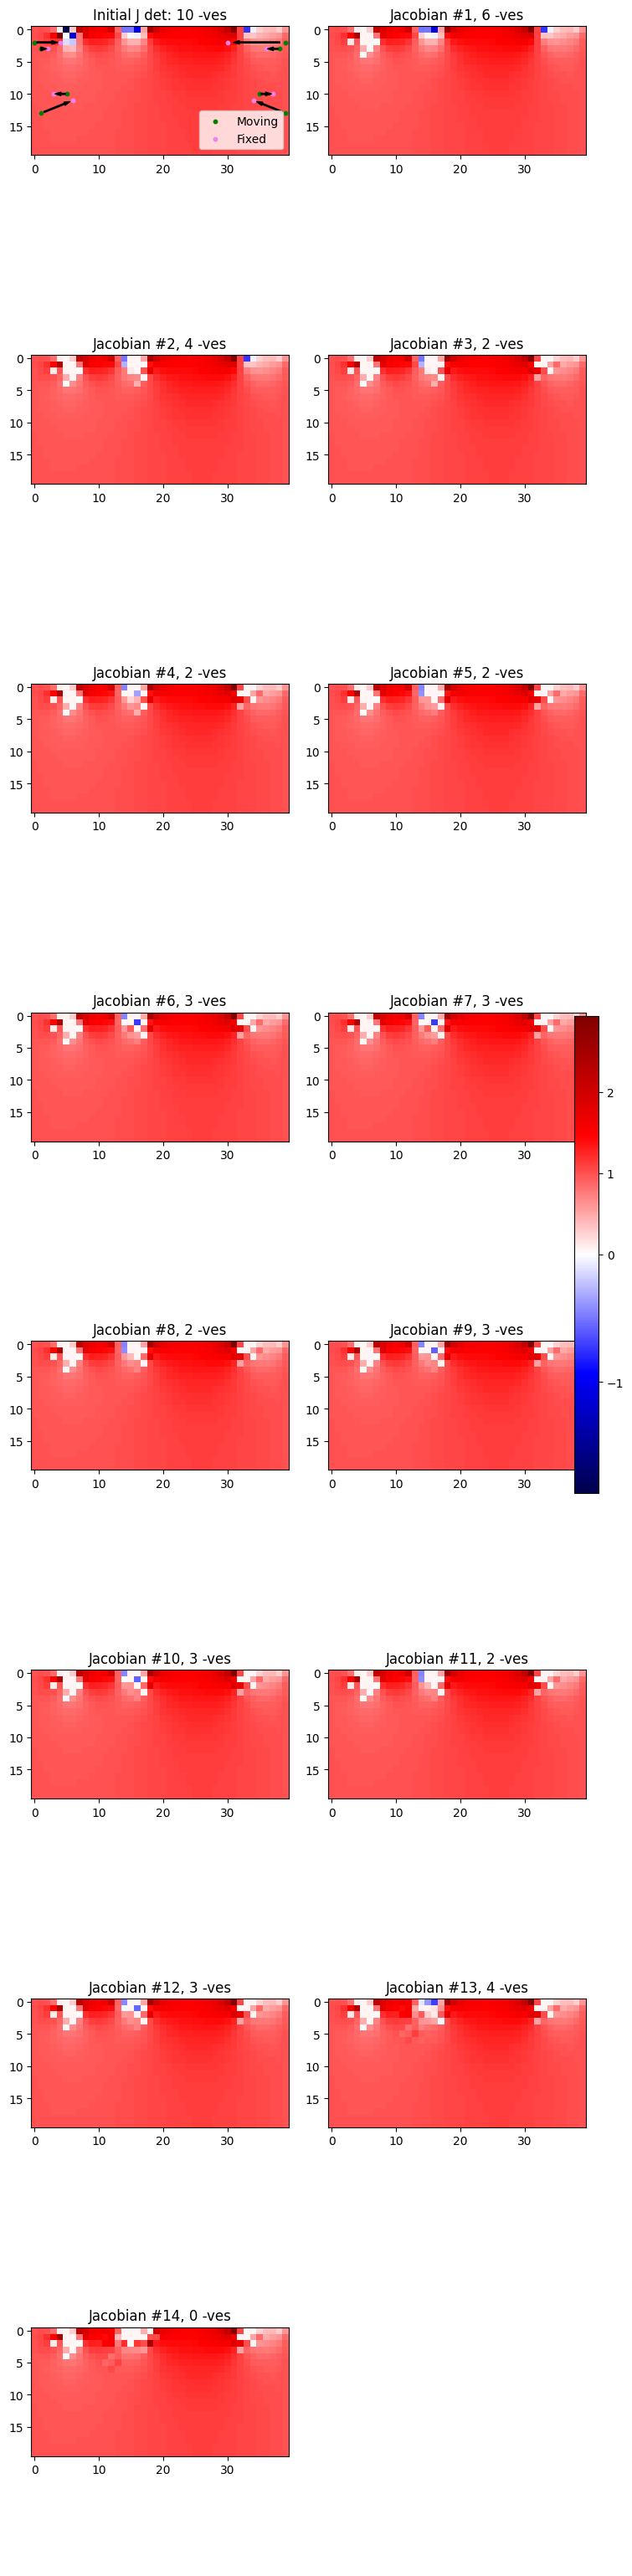

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -5.001665  9.002997  0.000000  1.998337 -1.871078  2.938822
final   -5.001665  9.002997 -3.768399  2.538757  0.024312  2.876044
meshgrid shape for plot: (20, 40)


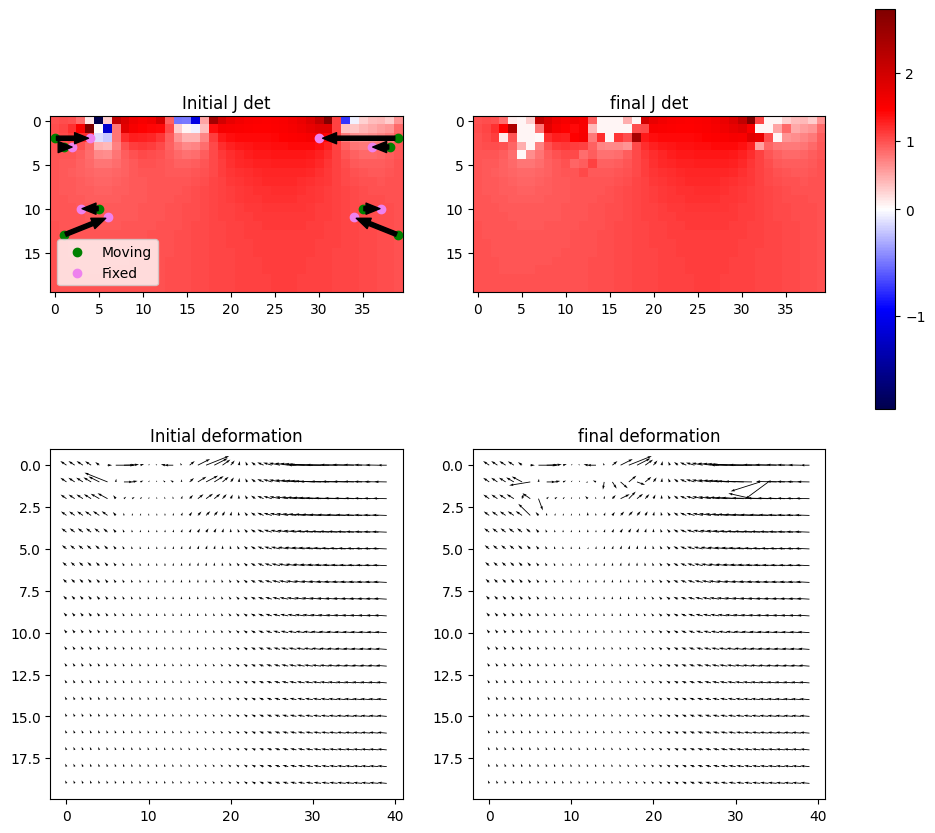

In [20]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
    [0, 10, 5],
    [0, 13, 1],
    [0, 2, 39],
    [0, 3, 38],
    [0, 10, 35],
    [0, 13, 39],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
    [0, 10, 3],
    [0, 11, 6],
    [0, 2, 30],
    [0, 3, 36],
    [0, 10, 37],
    [0, 11, 34]
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [26, 44, 27, 28, 67, 43, 66, 68]
Iter 1: Analysing index 26: Original coord: (26, 0, 0), nearest: (26, 2, 0), jdet: -2.7830091042695875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.178608913560943
            Iterations: 81
            Function evaluations: 4368
            Gradient evaluations: 80
Optimisation for index 26 completed in 2.7330799102783203s
OP result error for index 26: 13.178608913560943
Iter 1 end: 3 -ve jacs now at [44 28 43] : SITK: [-1.45771465 -0.41333861 -0.15263588]
Iter 2: Analysing index 44: Original coord: (4, 1, 0), nearest: (4, 2, 0), jdet: -1.4577146507435725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.012773966559944
            Iterations: 103
            Function evaluations: 5432
            Gradient evaluations: 103
Optimisati

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


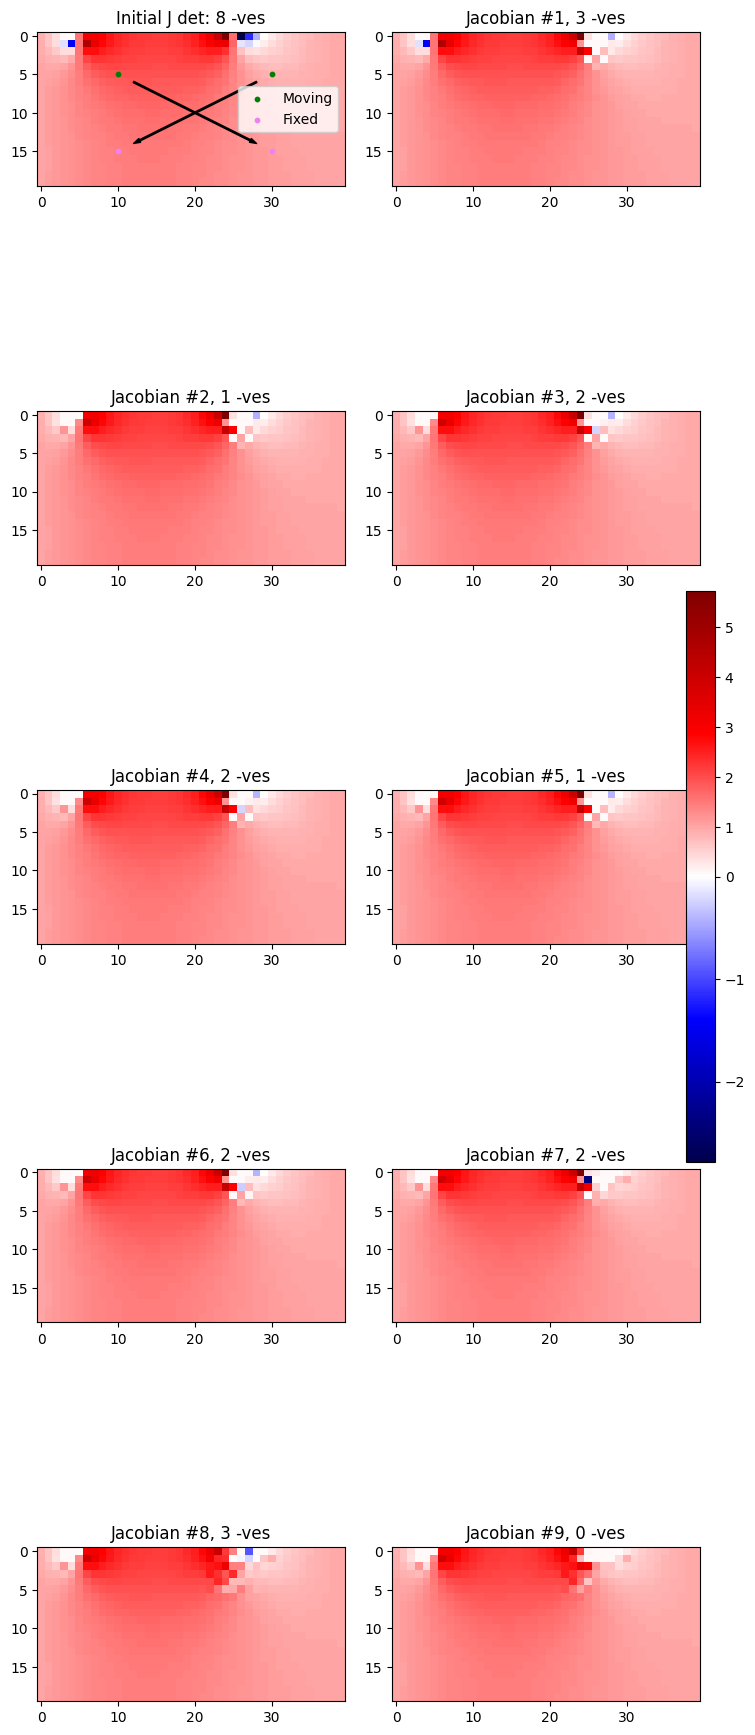

             x-def                 y-def            jacobian          
               min        max        min       max       min       max
initial -19.988363  19.988363 -10.036366 -9.027486 -2.783009  5.709197
final   -19.977188  19.988363 -11.968172 -8.989774  0.049999  4.087624
meshgrid shape for plot: (20, 40)


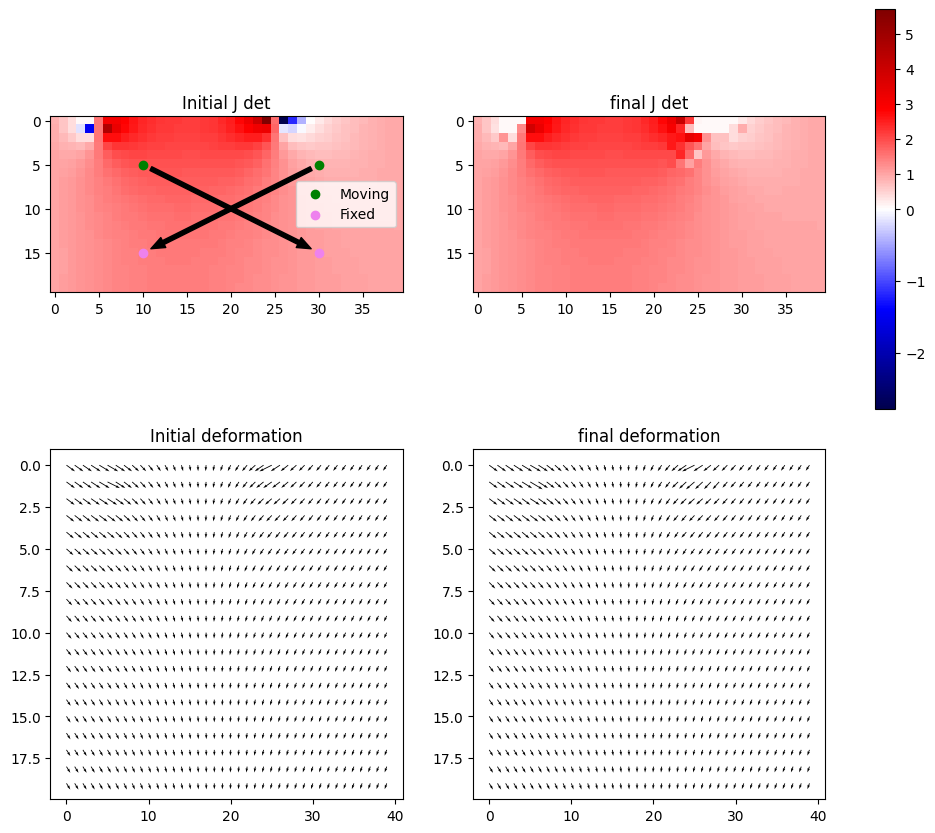

In [21]:
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [75, 34, 74, 35, 115]
Iter 1: Analysing index 75: Original coord: (35, 1, 0), nearest: (35, 2, 0), jdet: -0.8898328406385954
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.284593149260125
            Iterations: 92
            Function evaluations: 4881
            Gradient evaluations: 91
Optimisation for index 75 completed in 3.3444290161132812s
OP result error for index 75: 7.284593149260125
Iter 1 end: 2 -ve jacs now at [ 73 113] : SITK: [-0.05048385 -0.03018698]
Iter 2: jacobian at index 34 is +ve. skip.
Iter 3: jacobian at index 74 is +ve. skip.
Iter 4: jacobian at index 35 is +ve. skip.
Iter 5: jacobian at index 115 is +ve. skip.
Iter 6: Analysing index 73: Original coord: (33, 1, 0), nearest: (33, 2, 0), jdet: -0.05048385289689458
Iteration limit reached    (Exit mode 9)
            Current function val

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


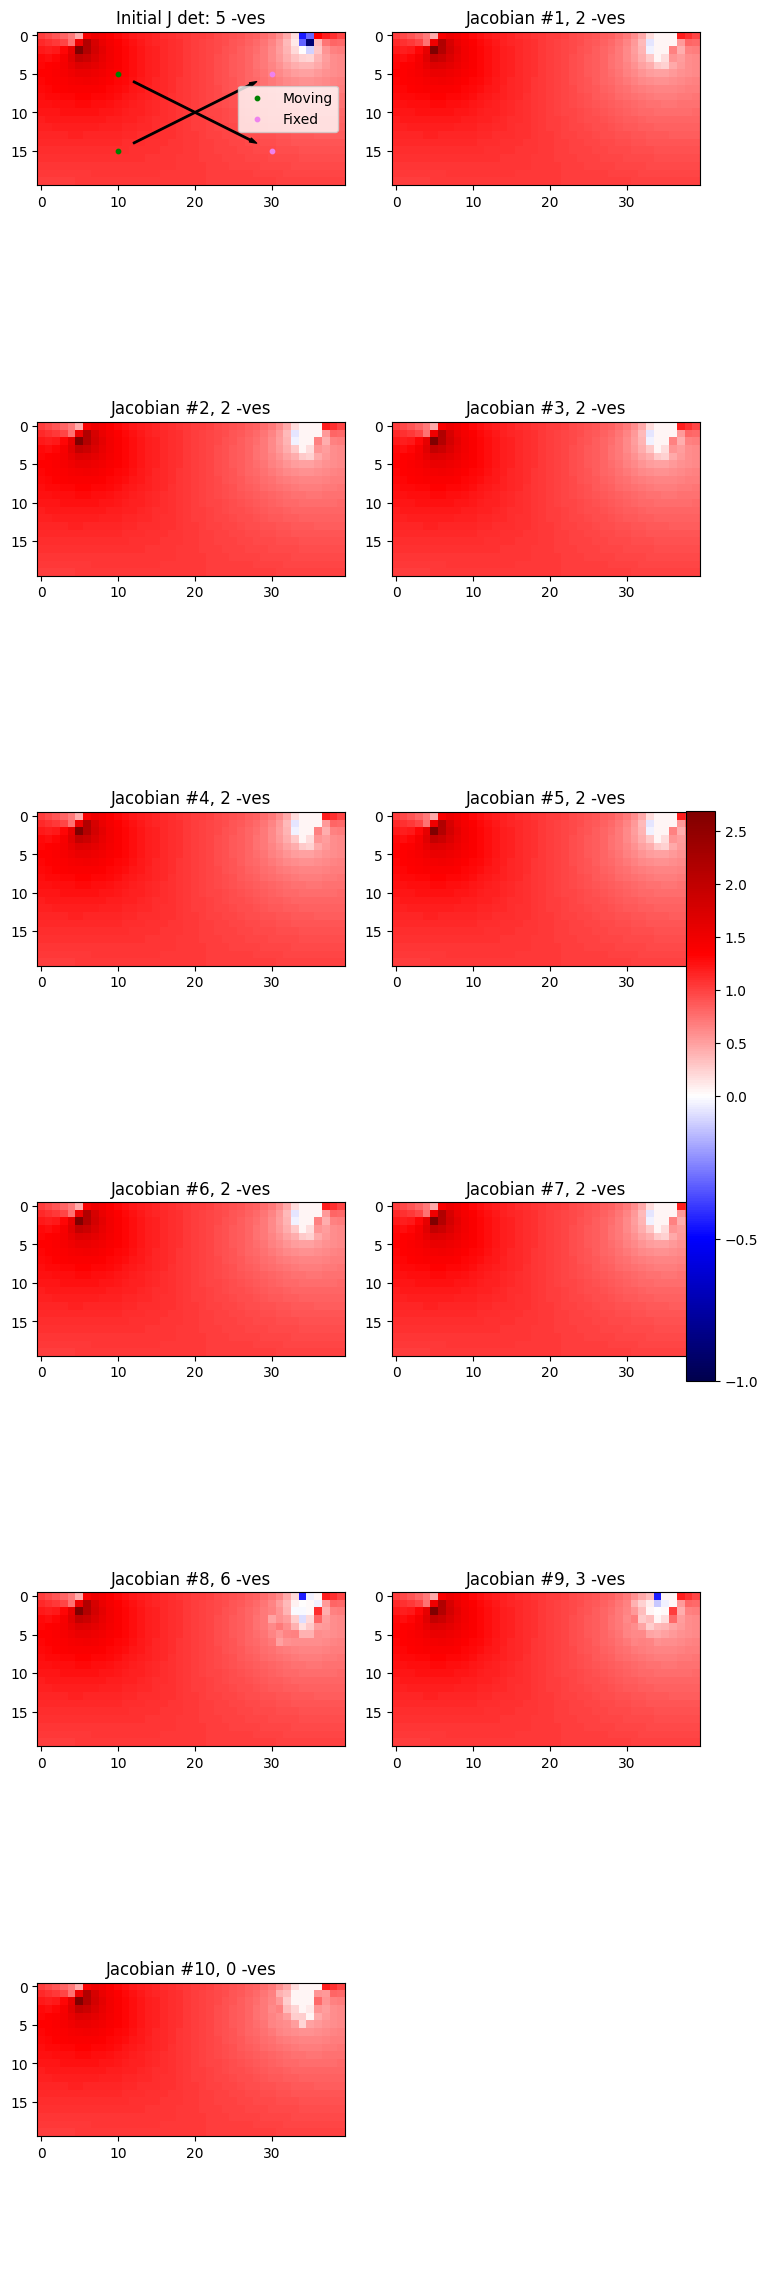

             x-def                y-def             jacobian          
               min       max        min        max       min       max
initial -19.995184 -15.34107 -10.002204  10.002204 -0.889833  2.691176
final   -19.995184 -15.34107 -10.002204  10.002204  0.050000  2.691176
meshgrid shape for plot: (20, 40)


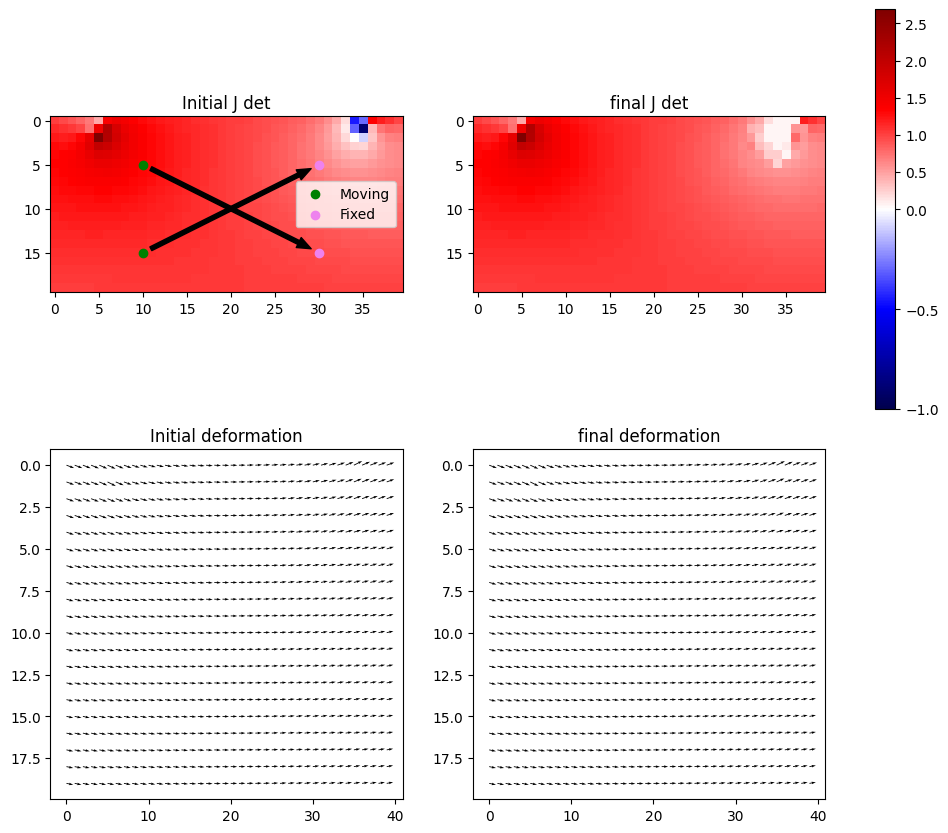

In [22]:
msample = np.array([
    [0, 5, 10],
    [0, 15, 10],
])
fsample = np.array([
    [0, 15, 30],
    [0, 5, 30],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [26, 44, 27, 28, 67, 43, 66, 68]
Iter 1: Analysing index 26: Original coord: (26, 0, 0), nearest: (26, 2, 0), jdet: -2.7830091042695875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13.178608913560943
            Iterations: 81
            Function evaluations: 4368
            Gradient evaluations: 80
Optimisation for index 26 completed in 2.750540018081665s
OP result error for index 26: 13.178608913560943
Iter 1 end: 3 -ve jacs now at [44 28 43] : SITK: [-1.45771465 -0.41333861 -0.15263588]
Iter 2: Analysing index 44: Original coord: (4, 1, 0), nearest: (4, 2, 0), jdet: -1.4577146507435725
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.012773966559944
            Iterations: 103
            Function evaluations: 5432
            Gradient evaluations: 103
Optimisatio

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


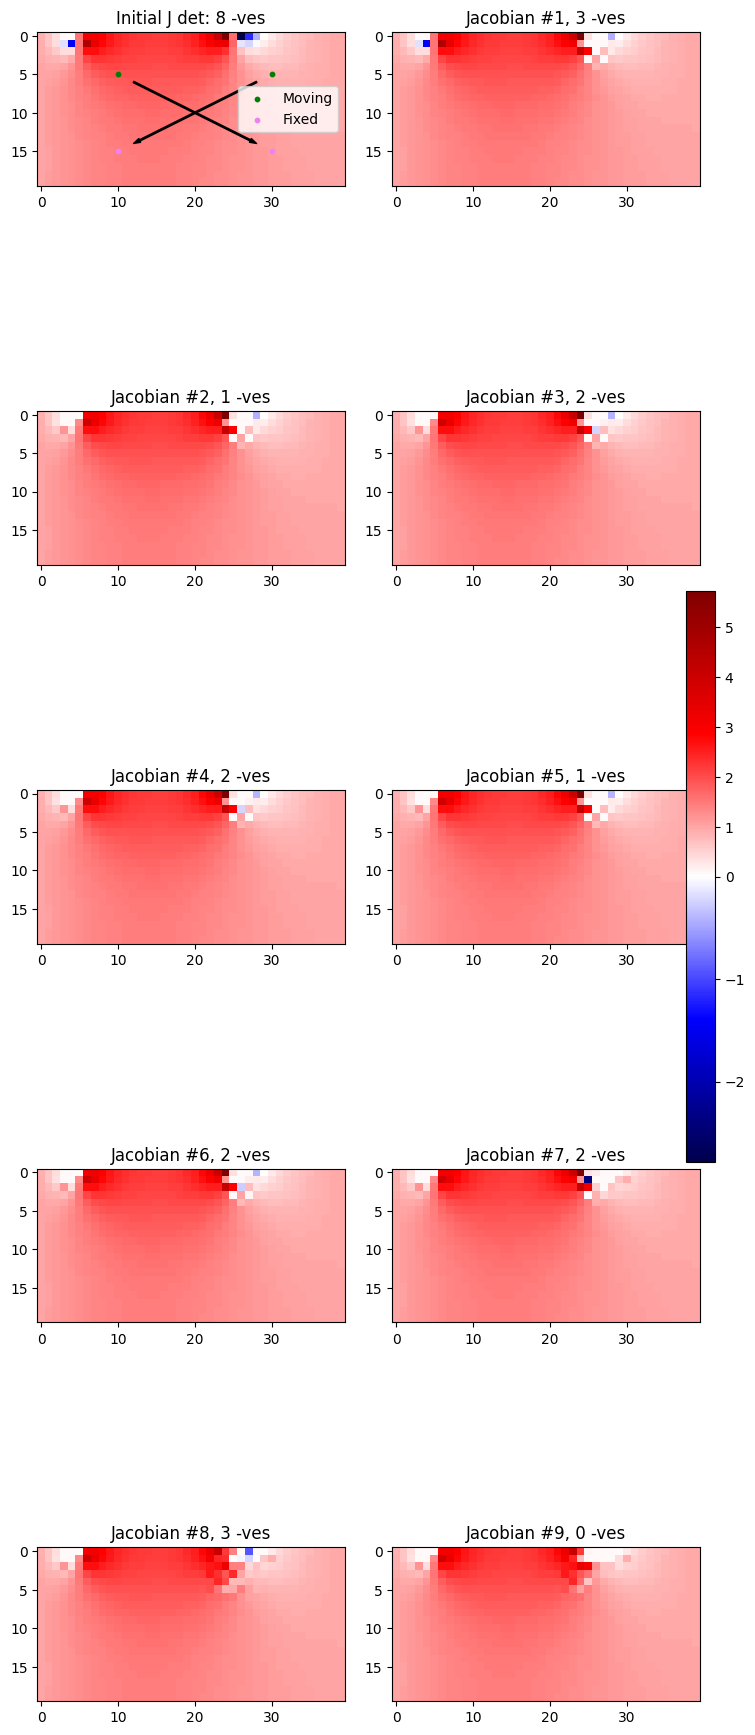

             x-def                 y-def            jacobian          
               min        max        min       max       min       max
initial -19.988363  19.988363 -10.036366 -9.027486 -2.783009  5.709197
final   -19.977188  19.988363 -11.968172 -8.989774  0.049999  4.087624
meshgrid shape for plot: (20, 40)


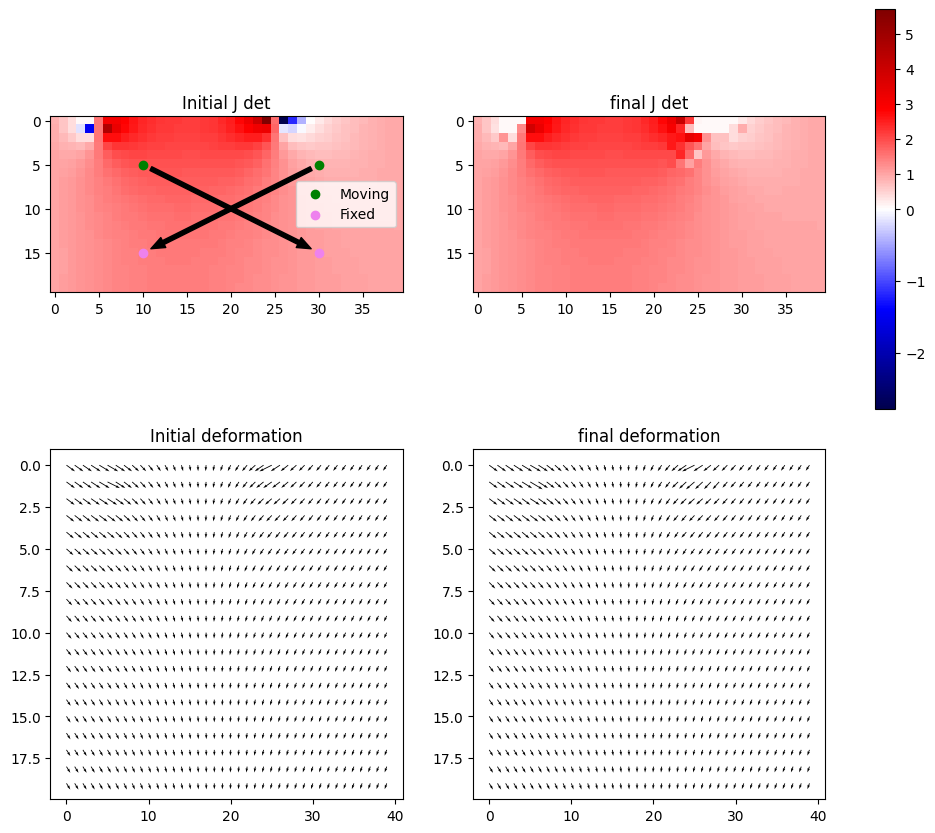

In [23]:
msample = np.array([
    [0, 5, 10],
    [0, 5, 30],
])
fsample = np.array([
    [0, 15, 30],
    [0, 15, 10],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [56, 36, 16, 17, 15, 35, 76, 55, 51, 9, 54, 50, 95, 10, 96, 49, 57]
Iter 1: Analysing index 56: Original coord: (16, 1, 0), nearest: (16, 2, 0), jdet: -2.8894616462248934
Iteration limit reached    (Exit mode 9)
            Current function value: 6.093907243265306e-07
            Iterations: 1000
            Function evaluations: 60705
            Gradient evaluations: 1000
Optimisation for index 56 completed in 37.783676862716675s
Optimisation failed:  Iteration limit reached
Iter 1 end: 17 -ve jacs now at [56 36 16 17 15 35 76 55 51  9 54 50 95 10 96 49 57] : SITK: [-2.88946161 -2.65730712 -2.21071753 -2.17680634 -1.92851593 -1.58841655 -1.55154387 -1.43149542 -0.86862691 -0.68957833 -0.45135253 -0.23619275 -0.20708392 -0.18852464 -0.17304708 -0.1478319  -0.03228728]
Iter 2: Analysing index 36: Original coord: (36, 0, 0), nearest: (36, 2, 0), jdet: -2.

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


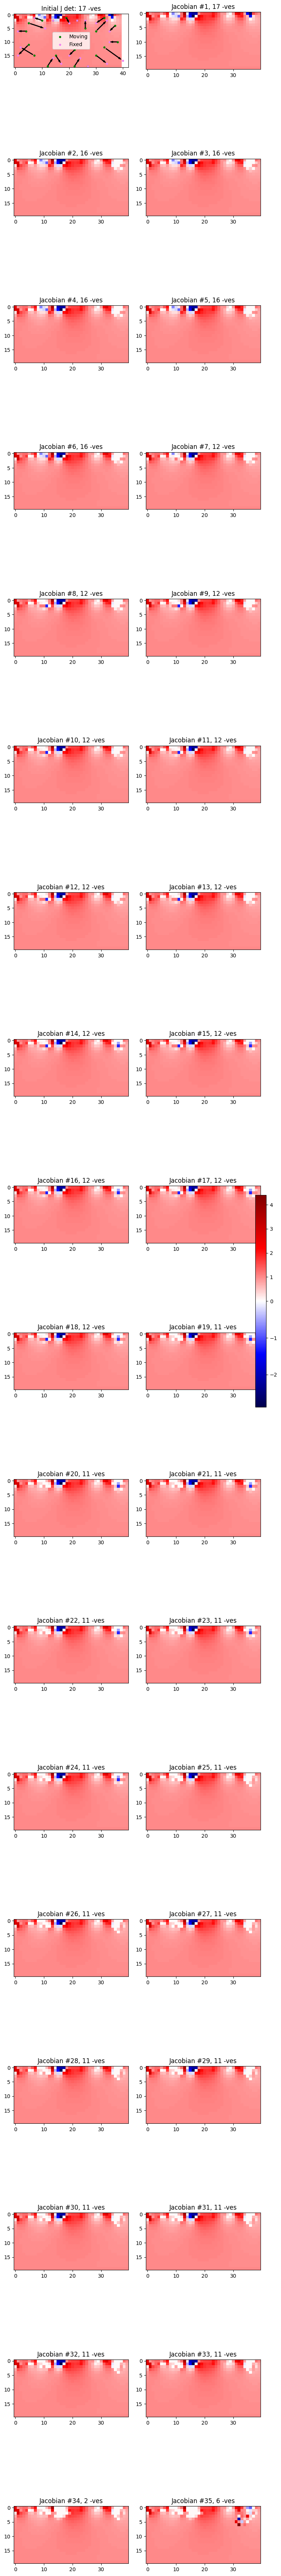

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -6.999329  4.999521 -4.999517  3.999614 -2.889462  3.665345
final   -4.278578  4.999521 -6.351844  3.999614 -2.098898  4.399229
meshgrid shape for plot: (20, 40)


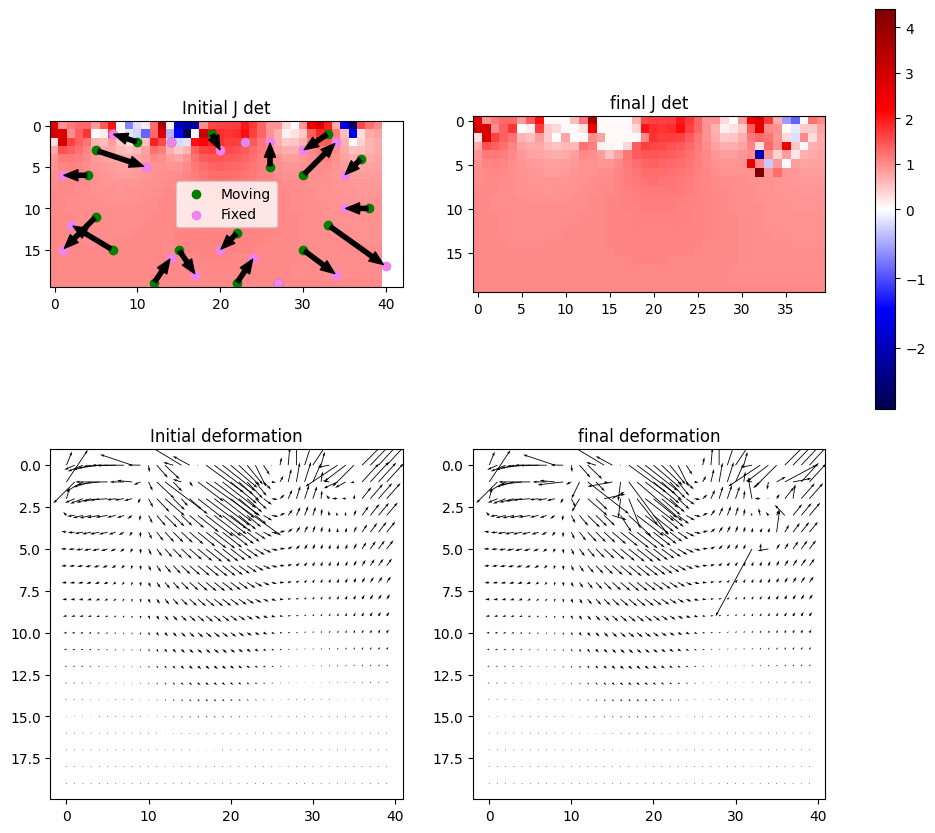

In [24]:
msample = np.array([
    [0, 2, 10],
    [0, 3, 5],
    [0, 6, 4],
    [0, 11, 5],
    [0, 15, 7],
    [0, 19, 12],
    [0, 15, 15],
    [0, 13, 22],
    [0, 19, 22],
    [0, 19, 27],
    [0, 15, 30],
    [0, 12, 33],
    [0, 10, 38],
    [0, 4, 37],
    [0, 6, 30],
    [0, 1, 33],
    [0, 5, 26],
    [0, 2, 23],
    [0, 1, 19],
    [0, 2, 14],
])
fsample = np.array([
    [0, 1, 7],
    [0, 5, 11],
    [0, 6, 1],
    [0, 15, 1],
    [0, 12, 2],
    [0, 16, 14],
    [0, 18, 17],
    [0, 15, 20],
    [0, 16, 24],
    [0, 19, 27],
    [0, 18, 34],
    [0, 17, 40],
    [0, 10, 35],
    [0, 6, 35],
    [0, 2, 34],
    [0, 3, 30],
    [0, 2, 26],
    [0, 2, 23],
    [0, 3, 20],
    [0, 2, 14],
])

fixed_sample = np.zeros((1, 20, 40))

run_lapl_and_correction(fixed_sample, msample, fsample)

## Testcases

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [3, 13, 2]
Iter 1: Analysing index 3: Original coord: (3, 0, 0), nearest: (3, 2, 0), jdet: -1.9997038720119469
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 82.22101549560891
            Iterations: 119
            Function evaluations: 6091
            Gradient evaluations: 115
Optimisation for index 3 completed in 3.8418757915496826s
Optimisation failed:  Positive directional derivative for linesearch
Iter 1 end: 4 -ve jacs now at [22 23 14 12] : SITK: [-2.95208951 -0.6199035  -0.21282667 -0.06996133]
Iter 2: jacobian at index 13 is +ve. skip.
Iter 3: jacobian at index 2 is +ve. skip.
Iter 4: Analysing index 22: Original coord: (2, 2, 0), nearest: (2, 2, 0), jdet: -2.9520895101052727
Iteration limit reached    (Exit mode 9)
            Current function value: 44.402459903856936
            Iterations

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


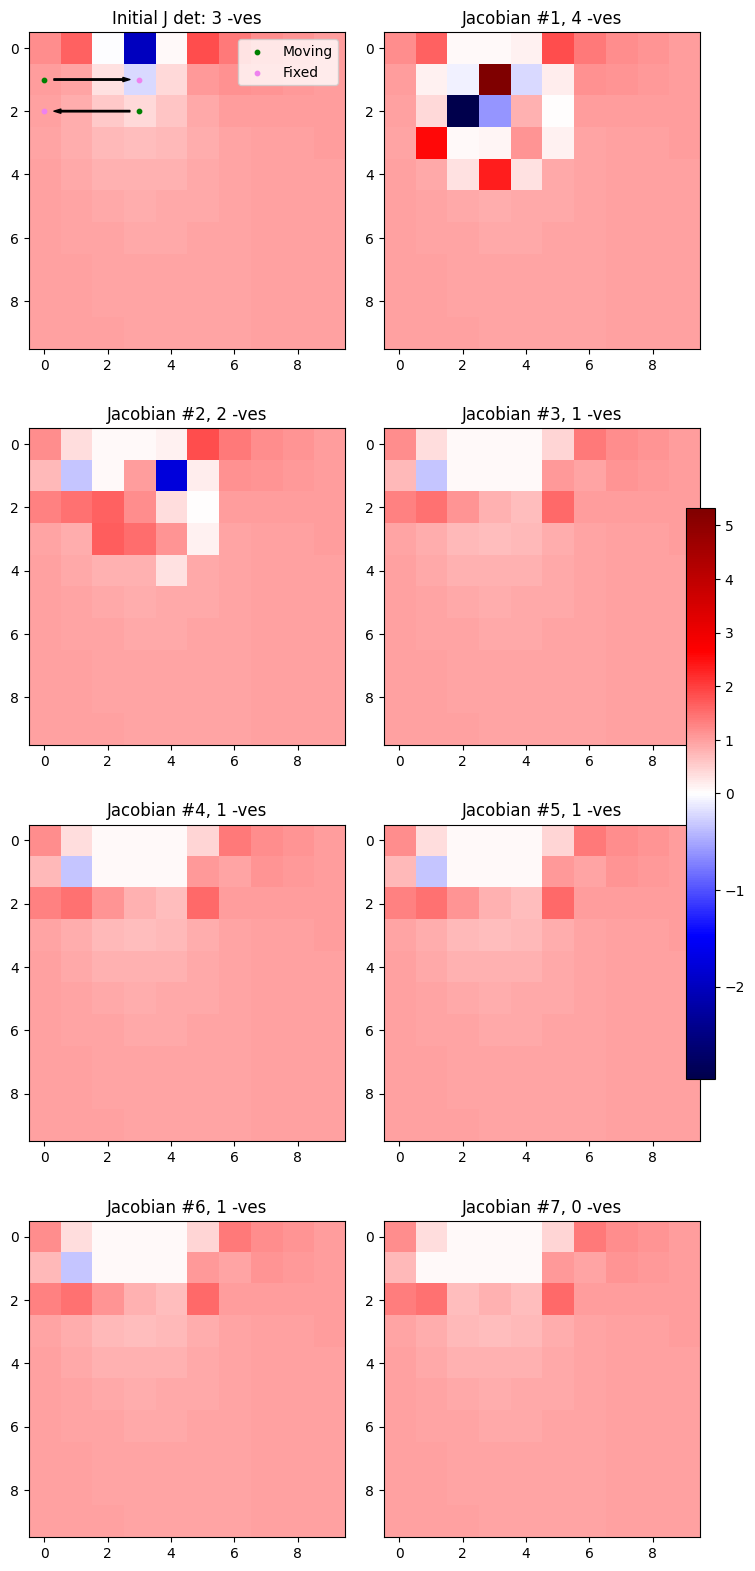

            x-def                y-def            jacobian          
              min       max        min       max       min       max
initial -2.999704  2.999704   0.000000  0.000000 -1.999704  1.852443
final   -2.999704  2.999704 -12.487138  0.000016  0.050000  1.549598
meshgrid shape for plot: (10, 10)


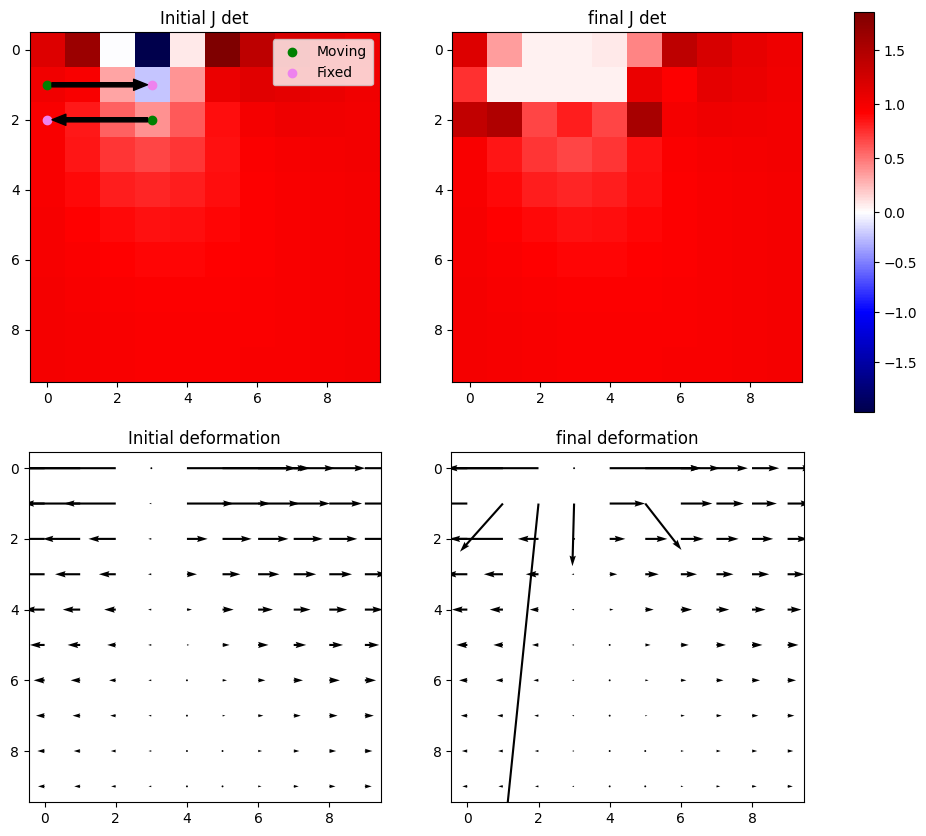

In [25]:
msample = np.array([
    [0, 1, 0],
    [0, 2, 3],
])
fsample = np.array([
    [0, 1, 3],
    [0, 2, 0],
])

fixed_sample = np.zeros((1, 10, 10)) # depth, rows, cols

run_lapl_and_correction(fixed_sample, msample, fsample)

# takes 15 mins and does not conclude on full 20x40 constraints
# 1.5mins on 10x10 constraints
# reduce constraints
# (10,5) - 50 vs 5 - 3.9s vs 0.15s
# (5,5) - 25 vs 5 - 0.35s vs 0.0645s
# (10, 10) - 100 vs 5 - 50s vs 0.46s
# (20, 20) - 400 vs 5 - waited for full one to run for 20min vs 1.5min

# 20x40 with 5 random constraints - 10.5 mins
# 20x40 run over the full thing - 174 min does not finish

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [14]
Iter 1: Analysing index 14: Original coord: (4, 1, 0), nearest: (4, 2, 0), jdet: -0.2157278167883259
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5295411769917929
            Iterations: 32
            Function evaluations: 1787
            Gradient evaluations: 31
Optimisation for index 14 completed in 1.149954080581665s
OP result error for index 14: 0.5295411769917929
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Total time taken for iterative SLSQP : 1.2992751598358154 split as [1.149954080581665]
Initial error: 8.301991792387227, final error: 9.162808530309489, deviation: 0.5294587877910784


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


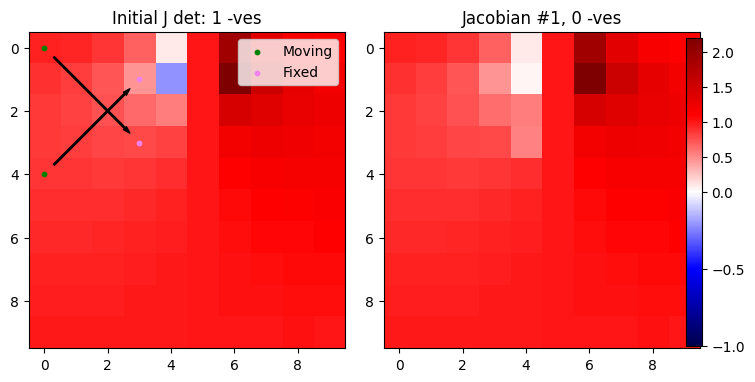

            x-def              y-def            jacobian         
              min      max       min       max       min      max
initial -3.006613 -2.97202 -2.999864  2.999864 -0.215728  2.19790
final   -3.006613 -2.97202 -2.999864  2.999864  0.050004  2.19787
meshgrid shape for plot: (10, 10)


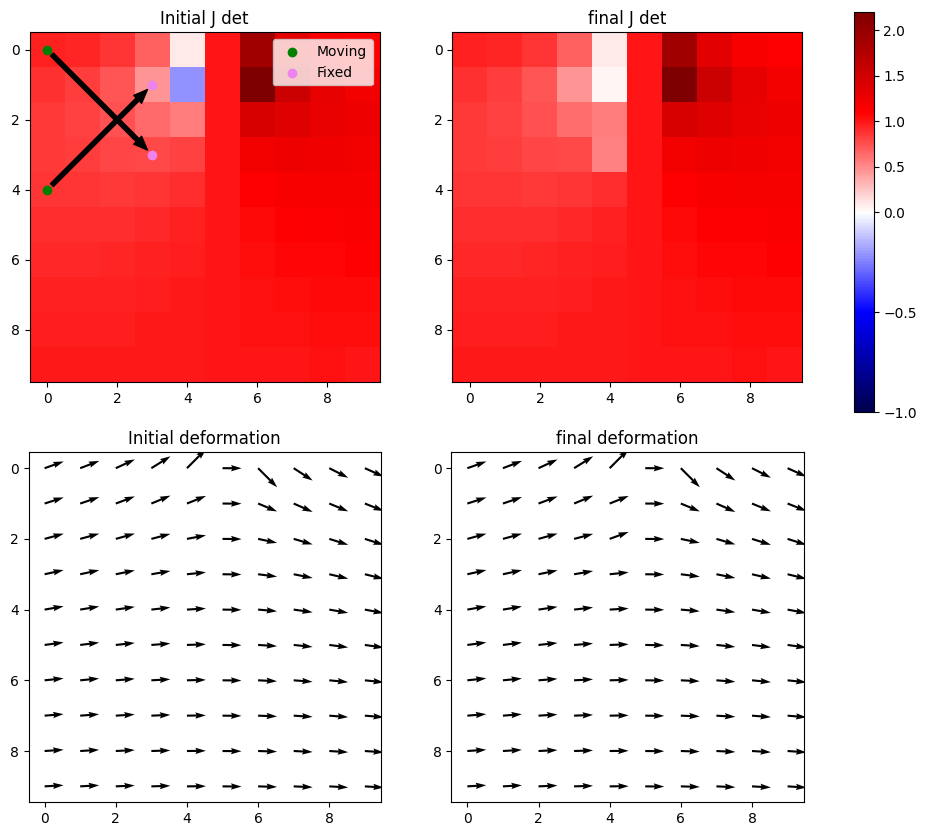

In [26]:
msample = np.array([
    [0, 0, 0],
    [0, 4, 0],
])
fsample = np.array([
    [0, 3, 3],
    [0, 1, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [13]
Iter 1: Analysing index 13: Original coord: (3, 1, 0), nearest: (3, 2, 0), jdet: -0.18474404472656492
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.4696407135618293
            Iterations: 38
            Function evaluations: 2143
            Gradient evaluations: 38
Optimisation for index 13 completed in 1.3559489250183105s
OP result error for index 13: 0.4696407135618293
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Total time taken for iterative SLSQP : 1.5190989971160889 split as [1.3559489250183105]
Initial error: 8.301903173025687, final error: 9.032328630062203, deviation: 0.4694851819761232


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


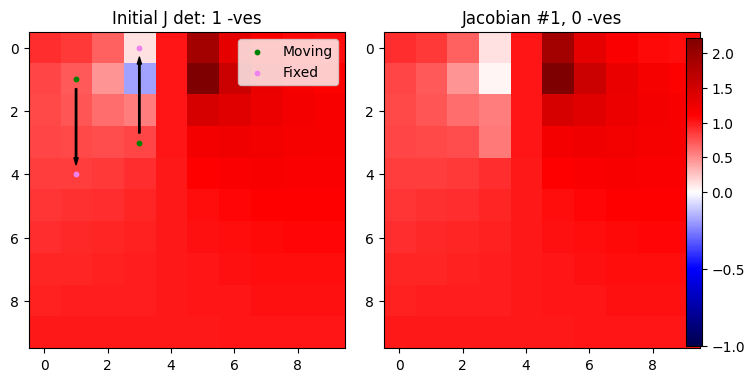

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial  0.000000  0.000000 -2.999864  2.999864 -0.184744  2.216894
final   -0.000004  0.000051 -2.999864  2.999864  0.050000  2.216837
meshgrid shape for plot: (10, 10)


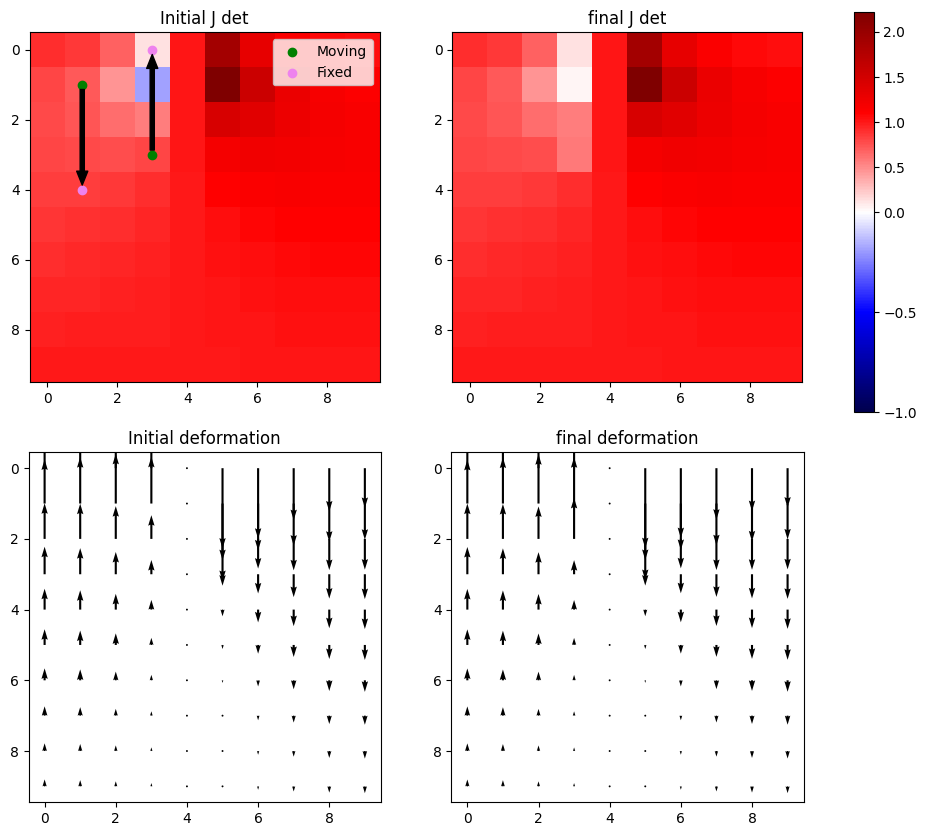

In [27]:
msample = np.array([
    [0, 1, 1],
    [0, 3, 3],
])
fsample = np.array([
    [0, 4, 1],
    [0, 0, 3],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

deformation shape: (3, 1, 10, 10)
deformation_i shape: (3, 1, 10, 10), phi_init shape: (2, 10, 10)
init: Negative Jacobians found at [5, 6]
Iter 1: Analysing index 5: Original coord: (5, 0, 0), nearest: (5, 2, 0), jdet: -0.21700094391725067
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.186120445339761
            Iterations: 120
            Function evaluations: 6313
            Gradient evaluations: 120
Optimisation for index 5 completed in 3.977430820465088s
OP result error for index 5: 6.186120445339761
Iter 1 end: 0 -ve jacs now at [] : SITK: []
Iter 2: jacobian at index 6 is +ve. skip.
Total time taken for iterative SLSQP : 4.131876707077026 split as [3.977430820465088]
Initial error: 6.566029817740786, final error: 18.191929461468902, deviation: 3.622252731767933


/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


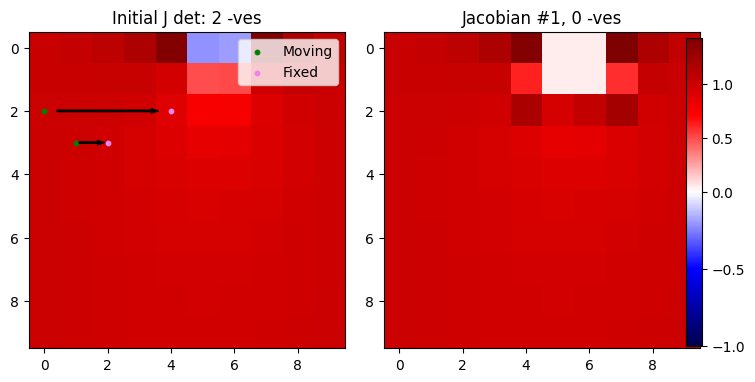

            x-def               y-def            jacobian          
              min       max       min       max       min       max
initial -3.999655 -0.999914  0.000000  0.000000 -0.217001  1.428312
final   -3.999655 -0.999914 -2.516344  0.000003  0.050000  1.428312
meshgrid shape for plot: (10, 10)


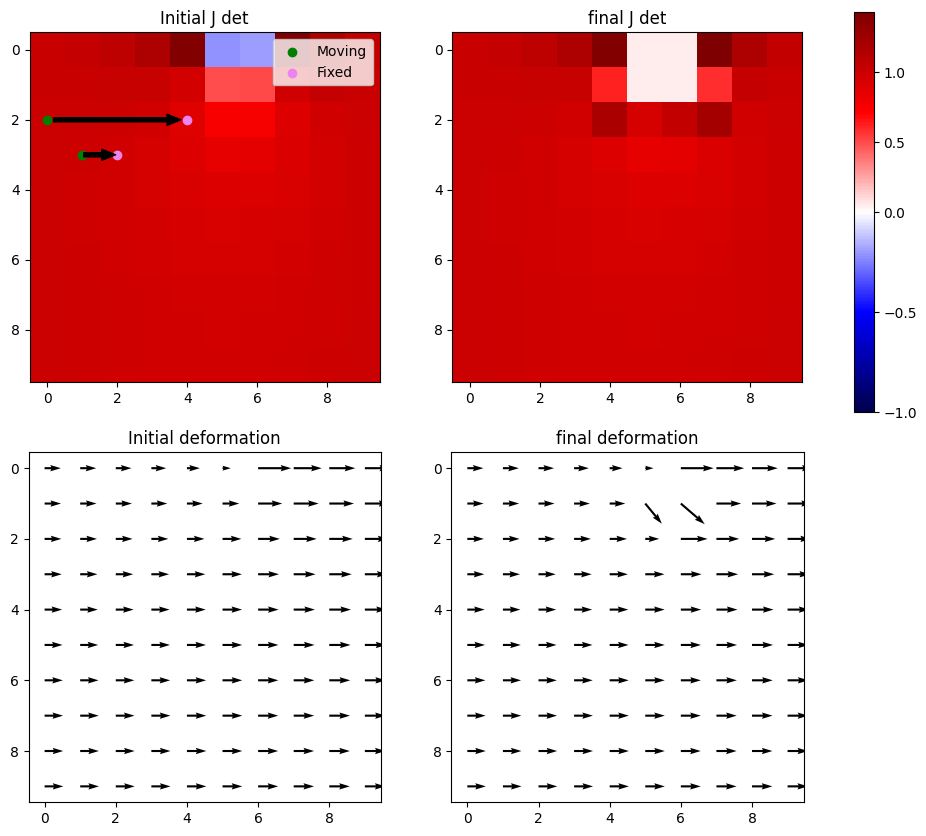

In [28]:
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
])

fixed_sample = np.zeros((1, 10, 10))
#test_grad(fixed_sample, msample, fsample)
#test_scipy(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, msample, fsample)
run_lapl_and_correction(fixed_sample, msample, fsample)

(15, 3) (15, 3)
deformation shape: (3, 1, 20, 40)
deformation_i shape: (3, 1, 20, 40), phi_init shape: (2, 20, 40)
init: Negative Jacobians found at [33, 34, 35, 17, 21, 18, 74, 73, 26, 25, 75, 22, 114, 48, 113, 115, 24, 65, 32, 66, 36, 64, 76, 154, 72, 155, 153, 62, 63, 116, 105, 57, 23, 104, 194, 112, 47, 106, 195, 156, 193, 61, 103, 152]
Iter 1: Analysing index 33: Original coord: (33, 0, 0), nearest: (33, 2, 0), jdet: -9.63056143072064
Iteration limit reached    (Exit mode 9)
            Current function value: 4.398998870613902e-06
            Iterations: 1000
            Function evaluations: 60759
            Gradient evaluations: 1000
Optimisation for index 33 completed in 456.86779499053955s
Optimisation failed:  Iteration limit reached
Iter 1 end: 44 -ve jacs now at [ 33  34  35  17  21  18  74  73  26  25  75  22 114  48 113 115  24  65  32  66  36  64  76 154  72 155 153  62  63 116 105  57  23 104 194 112  47 106 195 156 193  61 103 152] : SITK: [-9.63056141 -7.16528968 -6

/var/folders/pj/ny1dgkl90cj0mpph_t0mvd000000gn/T/ipykernel_82731/1233820171.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


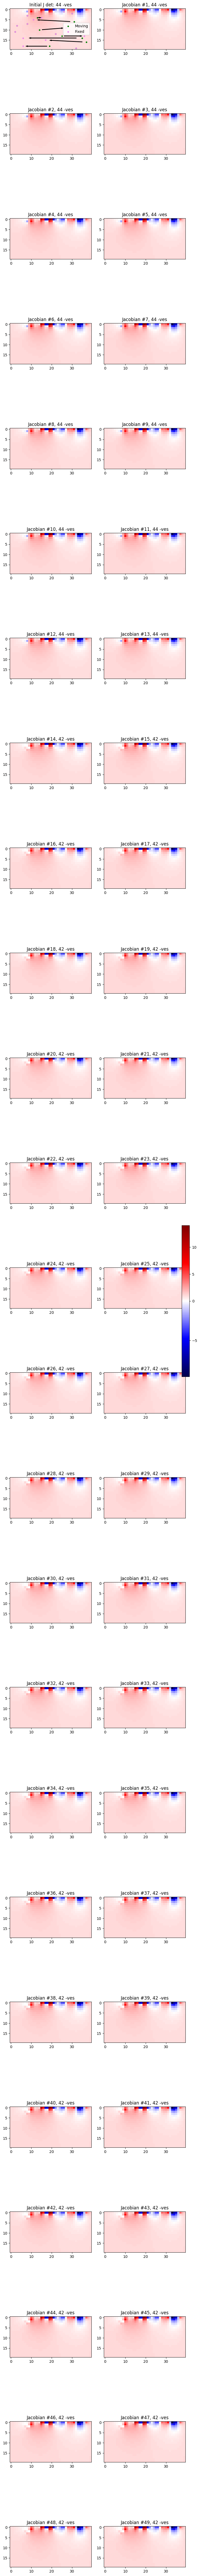

             x-def               y-def            jacobian           
               min       max       min       max       min        max
initial -13.000722  29.00161  0.000000  0.999538 -9.630561  14.027545
final   -13.000722  29.00161 -1.646725  0.999538 -9.630561  14.027545
meshgrid shape for plot: (20, 40)


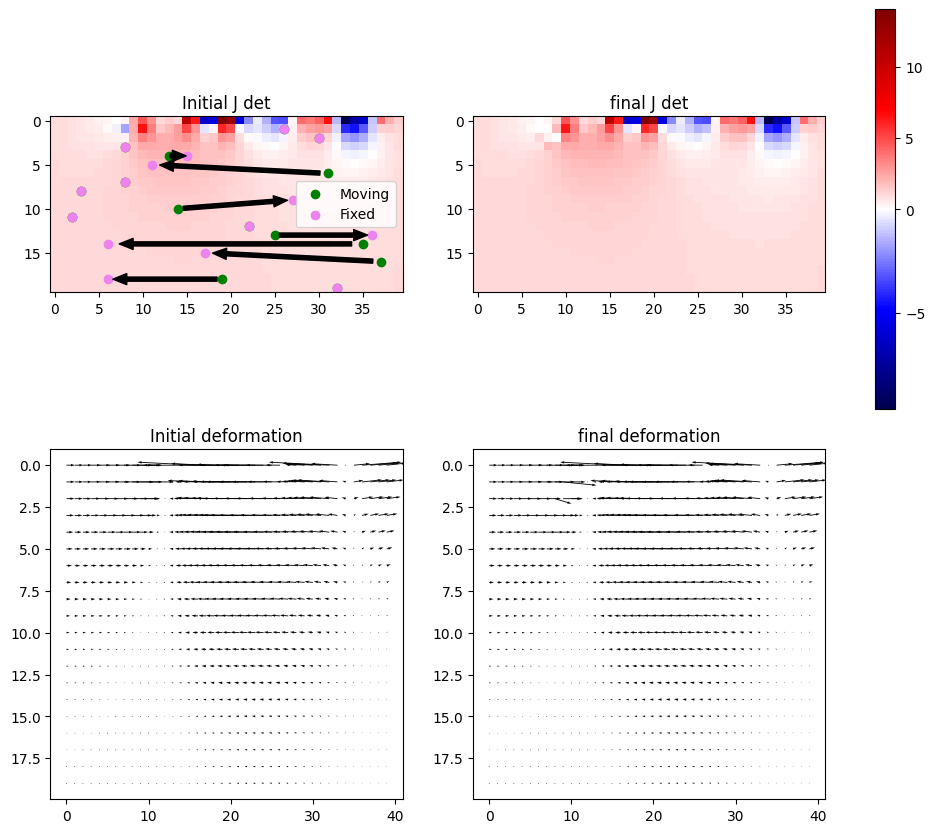

In [29]:
# data analysis

# Create sample set of points
mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
#print(mpoints.shape, fpoints.shape) 

fixed_sample = np.zeros((1, 20, 40))

# z values in mpoints, fpoints are for 3 slices numbered 0,1,2
slice_no = 1

# use 
mask = mpoints[:,0]==slice_no
new_mpoints = mpoints[mask].copy()
new_mpoints[:,0] = 0

mask = fpoints[:,0]==slice_no
new_fpoints = fpoints[mask].copy()
new_fpoints[:,0] = 0

print(new_mpoints.shape, new_fpoints.shape)


#test_grad(fixed_sample, msample, fsample)
#red_test_scipy(fixed_sample, new_mpoints[:5], new_fpoints[:5])
run_lapl_and_correction(fixed_sample, new_mpoints, new_fpoints)

## Real slice

In [ ]:
# # data analysis

# # Create sample set of points
# mpoints_path = "../data/corrected_correspondences_count_touching/mpoints.npy"
# fpoints_path = "../data/corrected_correspondences_count_touching/fpoints.npy"

# mpoints, fpoints = correspondences.downsample_points(mpoints_path, fpoints_path, debug=False)
# #print(mpoints.shape, fpoints.shape) 

# deformation_field_path = "../data/base_unique_correspondences/registered_output/deformation3d.npy"
# deformation_field = np.load(deformation_field_path)

# # select a slice
# def_shape = deformation_field.shape
# print(def_shape)
# deformation_i = deformation_field[:, 349].reshape((def_shape[0], 1, def_shape[2], def_shape[3]))
# print(deformation_i.shape)
# # z values in mpoints, fpoints are for 3 slices numbered 0,1,2
# slice_no = 0

# # use 
# mask = mpoints[:,0]==slice_no
# new_mpoints = mpoints[mask].copy()
# new_mpoints[:,0] = 0

# mask = fpoints[:,0]==slice_no
# new_fpoints = fpoints[mask].copy()
# new_fpoints[:,0] = 0

# print(new_mpoints.shape, new_fpoints.shape)

# phi_corrected, jacobians = iterative_with_jacobians(deformation_i)
# plot_jacobians_iteratively(jacobians, msample, fsample, methodName='SLSQP')
# plot_deformations(msample, fsample, deformation_i, phi_corrected, figsize=(10,10))
# # kept running for 450min

(3, 528, 320, 456)
(3, 1, 320, 456)
(13, 3) (13, 3)
deformation_i shape: (3, 1, 320, 456), phi_init shape: (2, 320, 456)
init: Negative Jacobians found at [82743, 64049, 57319, 80913, 62781, 83198, 63237, 38853, 78689, 10361, 38396, 58520, 109656, 91391, 25316, 82288, 50847, 57775, 62678, 99242, 52970, 66375, 59346, 62324, 63133, 52513, 96916, 65973, 69566, 97397, 85461, 10816, 64504, 58427, 47199, 110113, 96062, 64088, 42501, 91390, 9705, 49632, 97853, 44070, 43615, 113762, 41724, 31066, 31523, 8903, 93171, 81370, 96519, 71390, 49473, 88644, 91853, 85537, 72755, 107939, 11735, 75366, 68916, 76026, 85064, 42958, 82389, 63321, 110677, 81112, 78943, 37046, 106029, 20349, 57320, 81416, 89186, 112687, 25317, 49774, 59345, 33396, 47962, 60343, 51223, 73744, 63631, 65981, 90935, 39260, 87298, 91846, 41911, 119558, 45521, 29478, 54747, 98308, 72478, 92761, 8798, 33853, 82846, 80456, 31799, 105295, 91874, 113142, 70935, 84149, 49177, 62325, 76857, 61039, 6538, 42366, 85480, 73846, 45066, 96943

: 

## Jdet function testing